In [1]:
import pandas as pd

# === Load each relevant dataset === #
account_dim = pd.read_csv(r"D:\sports analytics projects\datathon\datathon\data\account_dim_20250325.csv")
rams_batch = pd.read_csv(r"D:\sports analytics projects\datathon\datathon\data\rams_batch_cur_20250325.csv")
fraud_cases = pd.read_csv(r"D:\sports analytics projects\datathon\datathon\data\fraud_claim_case_20250325.csv")
fraud_trans = pd.read_csv(r"D:\sports analytics projects\datathon\datathon\data\fraud_claim_tran_20250325.csv")


In [2]:
account_dim["ebill_ind"].fillna(account_dim["ebill_ind"].mode()[0], inplace=True)

account_dim["employee_code"].fillna("UNKNOWN", inplace=True)
account_dim["special_finance_charge_ind"].fillna("N", inplace=True)
account_dim["ext_status_reason_cd_desc"].fillna("UNKNOWN", inplace=True)
account_dim["pscc_ind"].fillna(0, inplace=True)


In [3]:
rams_batch.rename(columns={"cu_account_nbr": "current_account_nbr"}, inplace=True)
fraud_cases.rename(columns={"cu_account_nbr": "current_account_nbr"}, inplace=True)
fraud_trans.rename(columns={"cu_account_nbr": "current_account_nbr"}, inplace=True)

In [4]:
merged = account_dim.merge(rams_batch, on="current_account_nbr", how="left")

In [5]:
fraud_case_flag = fraud_cases.groupby("current_account_nbr").size().reset_index(name="has_fraud_case")
fraud_tran_flag = fraud_trans.groupby("current_account_nbr").size().reset_index(name="has_fraud_tran")
merged = merged.merge(fraud_case_flag, on="current_account_nbr", how="left")
merged = merged.merge(fraud_tran_flag, on="current_account_nbr", how="left")

In [6]:
merged["has_fraud_case"] = merged["has_fraud_case"].fillna(0).astype(int)
merged["has_fraud_tran"] = merged["has_fraud_tran"].fillna(0).astype(int)
merged.head()

,current_account_nbr,client_id,open_date,card_activation_date,card_activation_flag,ebill_ind,date_in_collection,overlimit_type_flag,payment_hist_1_12_mths,payment_hist_13_24_mths,...,cu_processing_date,mo_tot_sales_array_1,mo_tot_sales_array_2,mo_tot_sales_array_3,mo_tot_sales_array_4,mo_tot_sales_array_5,mo_tot_sales_array_6,ca_avg_utilz_lst_3_mnths,has_fraud_case,has_fraud_tran
0,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17T00:00:00.000-04:00,NaN,8,E,NaN,0,ZZZZZZIAZZZZ,ZZZZIIIQIIII,...,2025-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17T00:00:00.000-04:00,NaN,8,E,NaN,0,ZZZZZZIAZZZZ,ZZZZIIIQIIII,...,2024-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17T00:00:00.000-04:00,NaN,8,E,NaN,0,ZZZZZZIAZZZZ,ZZZZIIIQIIII,...,2025-03-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17T00:00:00.000-04:00,NaN,8,E,NaN,0,ZZZZZZIAZZZZ,ZZZZIIIQIIII,...,2024-10-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
4,nTgalbpd5Rsol7CA,YCTHAA278DC,2020-07-17T00:00:00.000-04:00,NaN,8,E,NaN,0,ZZZZZZIAZZZZ,ZZZZIIIQIIII,...,2024-12-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [7]:
merged.columns
# Optionally: Add indicator column for card never activated
merged["card_never_activated"] = merged["card_activation_date"].isna().astype(int)

# Drop rows that have no rams_batch data (they are not usable for classification)
merged = merged.dropna(subset=["cu_crd_line"])

# Reset index if needed
merged = merged.reset_index(drop=True)

# Replace missing dates with 0 (not in collection), others with 1 (was in collection)
merged["date_in_collection"] = merged["date_in_collection"].notna().astype(int)



In [ ]:
# Identify all categorical (object or string) columns
cat_cols = merged.select_dtypes(include=["object"]).columns.tolist()

# Display unique values for each to guide proper encoding
for col in cat_cols:
    print(f"\n{col}:")
    print(merged[col].dropna().unique())



current_account_nbr:
['nTgalbpd5Rsol7CA' 'xYaLrD9IvmbVl1PB' 'JM78WNziiRWgmL8e' ...
 'XiW0as5dJX6GJRi0' 'Xu1i4wqn776tFKU6' 'UU3UiLwIVVSikGPq']

client_id:
['YCTHAA278DC' 'CCSP489PLCC' 'HGBHARRFT984' 'OSELW263' 'ONEMV447COB'
 'ARPPYALC768' 'JTX290DC' 'AOHTME710DC' 'LKEB314DC' 'RTDECCI129DC'
 'LDJAUCP673' 'HNS962' 'CDVFQR626' 'YAUAPPLLDA934' 'SVRDCMSNAS887'
 'GOEOLG279' 'DGS176DC' 'OCAOAZNMN549' 'PJNOCC254' 'TJX513PLCC'
 'ZIONVRE794' 'CMSSSNAO606' 'BKLE911' 'ERWCJ164DC' 'LMEAAEG694DC'
 'RGALNW318DC' 'YEBA047COB' 'SEMEFLILLT443DC' 'DGS619PLCC' 'EORHVCN154DC'
 'ATBCLRAR077' 'RAEGLEMAEI254' 'BLARARTC432DC' 'WLCRPEJ828'
 'GRLNAW782PLCC' 'RTU038DC' 'WSLEO947DC' 'DUEAABLY384' 'LPPAAY817'
 'NCHSBPO661' 'NSH241DC' 'TEHAMO130' 'RNEDGIIVR336']

open_date:
['2020-07-17T00:00:00.000-04:00' '2024-07-24T00:00:00.000-04:00'
 '2024-05-05T00:00:00.000-04:00' ... '2018-02-27T00:00:00.000-05:00'
 '2018-08-14T00:00:00.000-04:00' '2025-03-19T00:00:00.000-04:00']

card_activation_date:
['2024-08-09T00:00:00.0

In [13]:
merged.isna().sum()

current_account_nbr                0
client_id                          0
open_date                          0
card_activation_date           14182
card_activation_flag               0
ebill_ind                          0
date_in_collection                 0
overlimit_type_flag                0
payment_hist_1_12_mths             0
payment_hist_13_24_mths            0
employee_code                      0
external_status_reason_code        0
special_finance_charge_ind         0
pscc_ind                           0
ext_status_reason_cd_desc          0
account_card_type                  0
cu_bhv_scr                         0
ca_cash_bal_pct_crd_line           0
ca_cash_bal_pct_cash_line          0
cu_nbr_days_dlq                    0
cu_nbr_of_plastics                 0
ca_avg_utilz_lst_6_mnths           0
cu_cash_line_am                    0
cu_crd_bureau_scr                  0
cu_crd_line                        0
cu_next_crd_line_rev_date          0
cu_cur_balance                     0
c

In [12]:
merged["utilization_ratio"] = merged["cu_cur_balance"] / merged["cu_crd_line"]
merged["credit_remaining_ratio"] = merged["cu_otb"] / merged["cu_crd_line"]

# Avoid divide-by-zero
merged["credit_remaining_ratio"].replace([float('inf'), -float('inf')], 0, inplace=True)
merged["utilization_ratio"].replace([float('inf'), -float('inf')], 0, inplace=True)

# Spending trend: simple difference between recent months
merged["spending_growth"] = (
    merged["mo_tot_sales_array_6"] - merged["mo_tot_sales_array_1"]
)

# Efficiency: spend per line
merged["spend_per_credit"] = merged[["mo_tot_sales_array_1", "mo_tot_sales_array_2",
                                     "mo_tot_sales_array_3", "mo_tot_sales_array_4",
                                     "mo_tot_sales_array_5", "mo_tot_sales_array_6"]].mean(axis=1) / merged["cu_crd_line"]


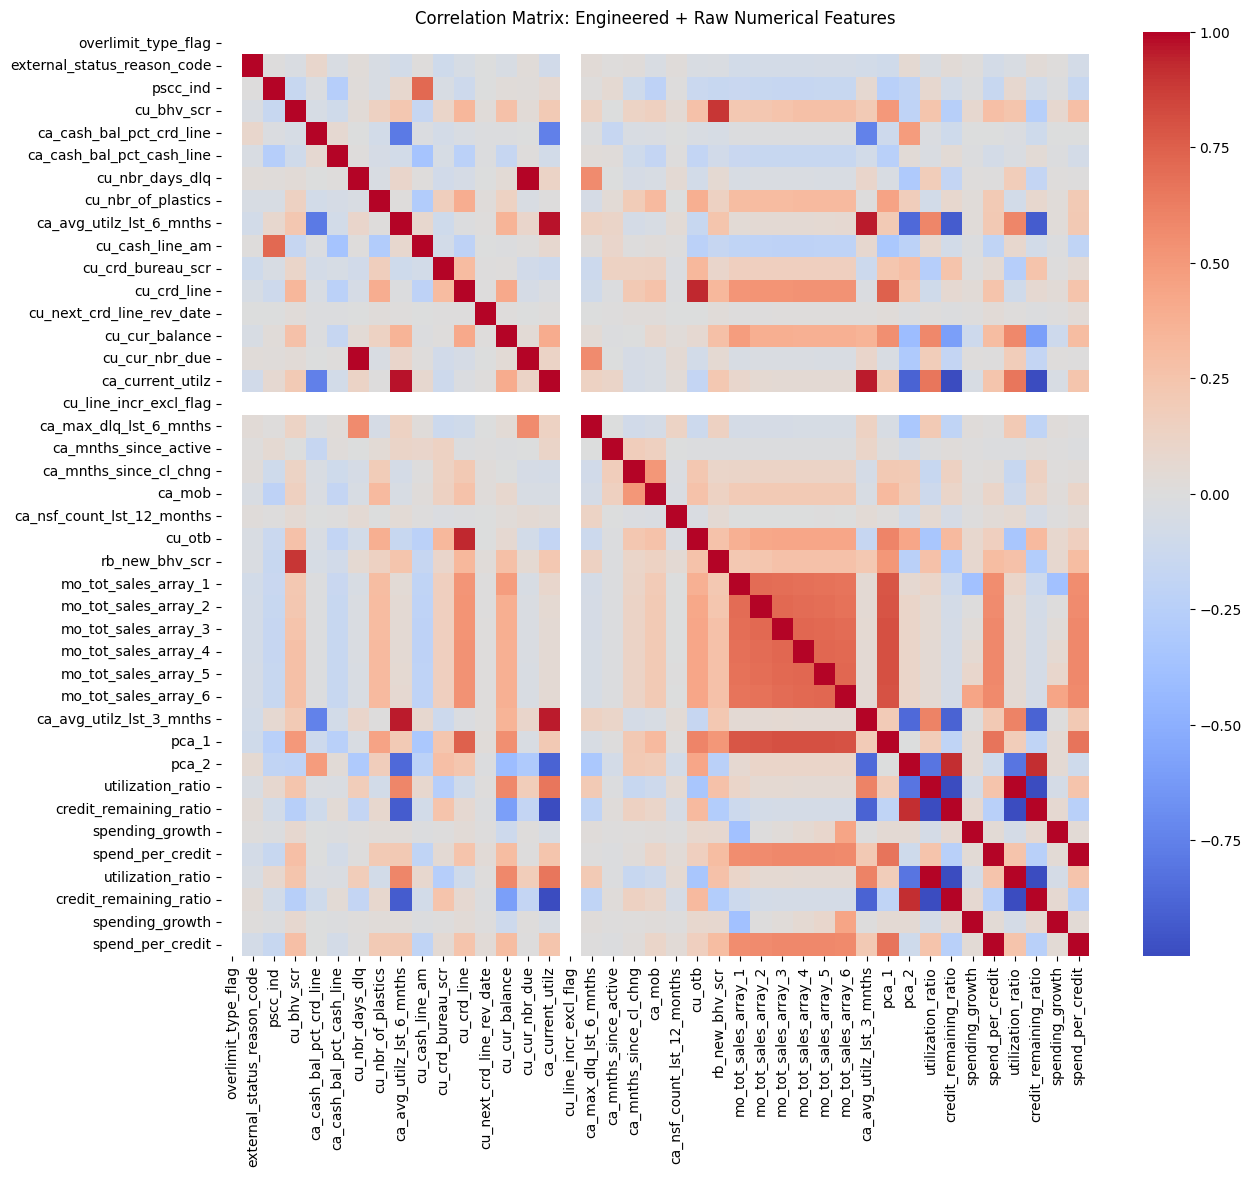

In [16]:
# Step 1: Select only numeric + engineered features
engineered_cols = ["utilization_ratio", "credit_remaining_ratio", "spending_growth", "spend_per_credit"]

X_num = merged.select_dtypes(include=["int64", "float64"]).copy()
X_num = X_num.loc[:, ~X_num.columns.str.contains("account_nbr", case=False)]
X_num.drop(columns=["cu_rnd_nbr"], errors="ignore", inplace=True)

# Add engineered features explicitly
X_num = pd.concat([X_num, merged[engineered_cols]], axis=1)

# Step 2: Correlation heatmap (to reveal strong groupings)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 12))
sns.heatmap(X_num.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix: Engineered + Raw Numerical Features")
plt.show()

# Step 3: Scale & PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_num.fillna(0, inplace=True)
X_scaled = StandardScaler().fit_transform(X_num)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged["pca_num_1"] = X_pca[:, 0]
merged["pca_num_2"] = X_pca[:, 1]


In [ ]:
X = [
    'mo_tot_sales_array_1', 'mo_tot_sales_array_2', 'mo_tot_sales_array_3',
    'mo_tot_sales_array_4', 'mo_tot_sales_array_5', 'mo_tot_sales_array_6',
    'cu_crd_line', 'cu_otb', 'cu_cur_balance', 'cu_bhv_scr'
]


In [17]:
# Select meaningful categoricals
cat_cols = ["account_card_type", "ebill_ind", "cu_line_incr_excl_flag"]

# Clean + inspect value counts
for col in cat_cols:
    print(f"\n{col}:\n", merged[col].value_counts())

# One-hot encode (optional, for combining later)
merged[cat_cols] = merged[cat_cols].fillna("Unknown")
merged["cu_line_incr_excl_flag"] = merged["cu_line_incr_excl_flag"].map({"Y": 1, "N": 0, "Unknown": 0})
encoded_cat = pd.get_dummies(merged[["account_card_type", "ebill_ind"]], drop_first=True)



account_card_type:
 account_card_type
DUAL CARD    49388
PLCC         47411
Name: count, dtype: int64

ebill_ind:
 ebill_ind
E           54120
\\\\\\""    28370
L           13640
B             390
D             279
Name: count, dtype: int64

cu_line_incr_excl_flag:
 cu_line_incr_excl_flag
0    96799
Name: count, dtype: int64


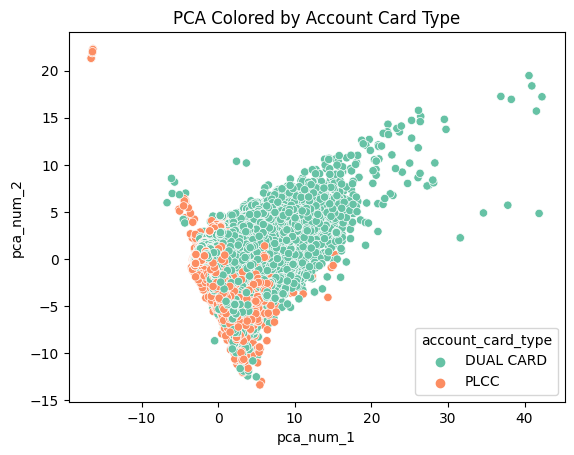

In [18]:
sns.scatterplot(data=merged, x="pca_num_1", y="pca_num_2", hue="account_card_type", palette="Set2")
plt.title("PCA Colored by Account Card Type")
plt.show()
